x = [-2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.77635684e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00  1.30000000e+00  1.40000000e+00  1.50000000e+00
  1.60000000e+00  1.70000000e+00  1.80000000e+00  1.90000000e+00]
y = [25.   23.43 21.92 20.47 19.08 17.75 16.48 15.27 14.12 13.03 12.   11.03
 10.12  9.27  8.48  7.75  7.08  6.47  5.92  5.43  5.    4.63  4.32  4.07
  3.88  3.75  3.68  3.67  3.72  3.83  4.    4.23  4.52  4.87  5.28  5.75
  6.28  6.87  7.52  8.23]


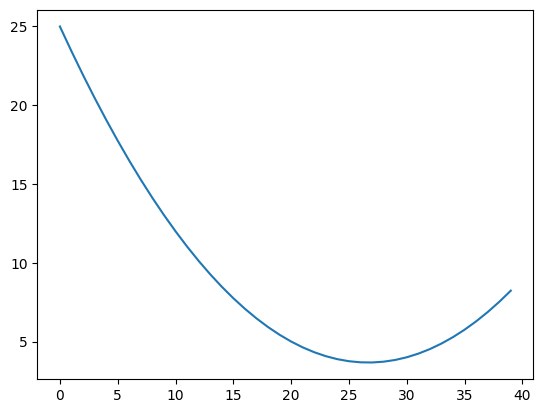

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import logging
import json
from typing import List, Tuple, Optional, Union, Dict, Any
from dataclasses import dataclass
from abc import ABC, abstractmethod
import unittest

def f(x):
  return 3*x**2 - 4*x + 5

x = np.arange(-2, 2, 0.1)
y = f(x)

print(f'x = {x}')
print(f'y = {y}')

plt.plot(y)

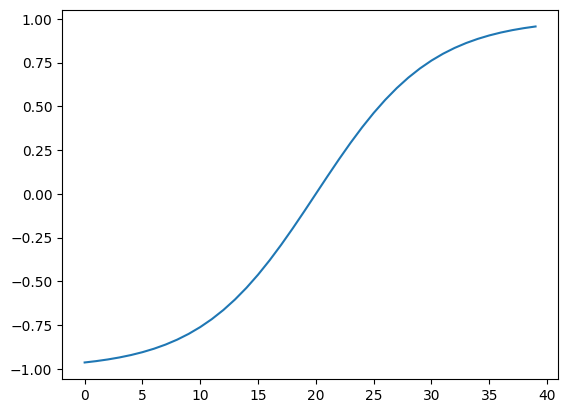

In [2]:
y = np.tanh(x)
plt.plot(y)

In [3]:
h = 0.000000000001
x = -3
d = (f(x + h) - f(x))/h
print(f'Derivative of f at {x} = {d}')

Derivative of f at -3 = -21.9984030991327


In [4]:
h = 0.000001

# inputs
a = 2.0
b = 3.0
c = -5.0

d1 = a*b + c
b += h
d2 = a*b + c

print(f'd1 = {d1}')
print(f'd2 = {d2}')
print(f'Rate of change of d wrt b = {(d2 - d1)/h}')

d1 = 1.0
d2 = 1.0000020000000003
Rate of change of d wrt b = 2.000000000279556


In [5]:
class Value:
  """Value class stores a scalar value and its gradient."""

  def __init__(self, data : Union[int, float], _children : Tuple = (), _operator : str = '', label : str = ''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._operator = _operator
    self._backward = lambda : None
    self.label = label

  def __add__(self, other : Union['Value', int, float]) -> 'Value':
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward

    return out

  def __mul__(self, other : Union['Value', int, float]) -> 'Value':
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data
    out._backward = _backward

    return out

  def exp(self) -> 'Value':
    clipped_data = max(min(self.data, 700), -700) # clipping the value to prevent overflow
    out = Value(math.exp(clipped_data), (self,), 'exp')

    def _backward():
      self.grad += out.grad * out.data
    out._backward = _backward

    return out

  def relu(self) -> 'Value':
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    def _backward():
      self.grad += (0 if self.data < 0 else 1) * out.grad
    out._backward = _backward

    return out

  def sigmoid(self) -> 'Value':
    # Adding numerical stability for sigmoid
    if self.data >= 0:
      exp_neg = math.exp(-self.data)
      sig = 1 / (1 + exp_neg)
    else:
      exp_pos = math.exp(self.data)
      sig = exp_pos / (1 + exp_pos)

    out = Value(sig, (self,), 'sigmoid')

    def _backward():
      self.grad += (sig * (1 - sig)) * out.grad
    out._backward = _backward

    return out

  def tanh(self) -> 'Value':
    # Adding numerical stability for tanh
    if self.data > 20:
      t = 1.0
    elif self.data < -20:
      t = -1.0
    else:
      exp_2x = math.exp(2 * self.data)
      t = (exp_2x - 1) / (exp_2x + 1)

    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def log(self) -> 'Value':
    # Natural logarithm with numerical stability
    safe_data = max(self.data, 1e-15)
    out = Value(math.log(safe_data), (self,), 'log')

    def _backward():
      self.grad += out.grad / safe_data
    out._backward = _backward

    return out

  def __pow__(self, other : Union[int, float]) -> 'Value':
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += out.grad * other * self.data**(other - 1)
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    return self * other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    return self + (-other)

  def __rsub__(self, other):
    return -self + other

  def __truediv__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    return self * other**-1

  def __rtruediv__(self, other):
    return other * self**-1

  def __repr__(self):
    return f'Value(data={self.data}, prev={self._prev}, label={self.label})'

  def backward(self):
    # Iterative topological sort to avoid recursion depth issues
    visited = set()
    topo = []

    # Use a stack for iterative DFS
    stack = [self]

    while stack:
      node = stack[-1]

      if node in visited:
        stack.pop()
        continue

      # Check if all children have been processed
      all_children_processed = True
      for child in node._prev:
        if child not in visited:
          stack.append(child)
          all_children_processed = False

      # If all children are processed, we can add this node to topo order
      if all_children_processed:
        visited.add(node)
        topo.append(node)
        stack.pop()

    # Run backward pass in reverse topological order
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._operator:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._operator, label = n._operator)
      # and connect this node to it
      dot.edge(uid + n._operator, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operator)

  return dot

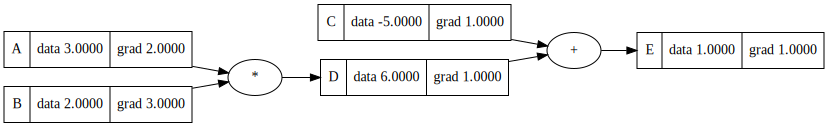

In [7]:
a = Value(3, label='A')
b = Value(2, label='B')
c = Value(-5, label='C')

d = a*b
d.label = 'D'
e = c + d
e.label = 'E'

e.backward()
draw_dot(e)

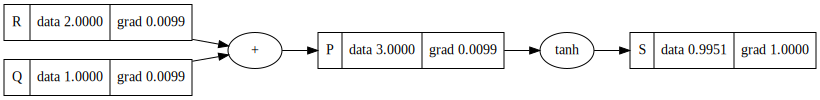

In [8]:
Q = Value(1, label='Q')
R = Value(2, label='R')
P = Q + R
P.label = 'P'
S = P.tanh()
S.label = 'S'

S.backward()
draw_dot(S)

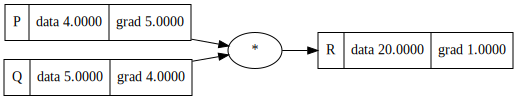

In [9]:
p = Value(4, label='P')
q = Value(5, label='Q')
r = p*q
r.label = 'R'
s = Value(7, label='S')
t = r + s
t.label = 'T'

r.backward()
draw_dot(r)

In [10]:
w1 = Value(-3, label='w1')
x1 = Value(2, label='x1')
w2 = Value(1, label='w2')
x2 = Value(0, label='x2')
b = Value(6.88137, label='b')
w1x1 = w1*x1
w1x1.label = 'w1x1'
w2x2 = w2*x2
w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2
w1x1w2x2.label = 'w1x1 + w2x2'
z = w1x1w2x2 + b
z.label = 'z'
e = (2*z).exp()
e.label = 'e'
y = (e - 1)/(e + 1)
y.label = 'y'
y

Value(data=0.7071049876722272, prev={Value(data=4.828385311532177, prev={Value(data=5.828385311532177, prev={Value(data=1.7627400000000009, prev={Value(data=2, prev=set(), label=), Value(data=0.8813700000000004, prev={Value(data=-6, prev={Value(data=0, prev={Value(data=1, prev=set(), label=w2), Value(data=0, prev=set(), label=x2)}, label=w2x2), Value(data=-6, prev={Value(data=-3, prev=set(), label=w1), Value(data=2, prev=set(), label=x1)}, label=w1x1)}, label=w1x1 + w2x2), Value(data=6.88137, prev=set(), label=b)}, label=z)}, label=)}, label=e), Value(data=-1, prev={Value(data=-1, prev=set(), label=), Value(data=1, prev=set(), label=)}, label=)}, label=), Value(data=0.14644750616388644, prev={Value(data=6.828385311532177, prev={Value(data=5.828385311532177, prev={Value(data=1.7627400000000009, prev={Value(data=2, prev=set(), label=), Value(data=0.8813700000000004, prev={Value(data=-6, prev={Value(data=0, prev={Value(data=1, prev=set(), label=w2), Value(data=0, prev=set(), label=x2)}, l

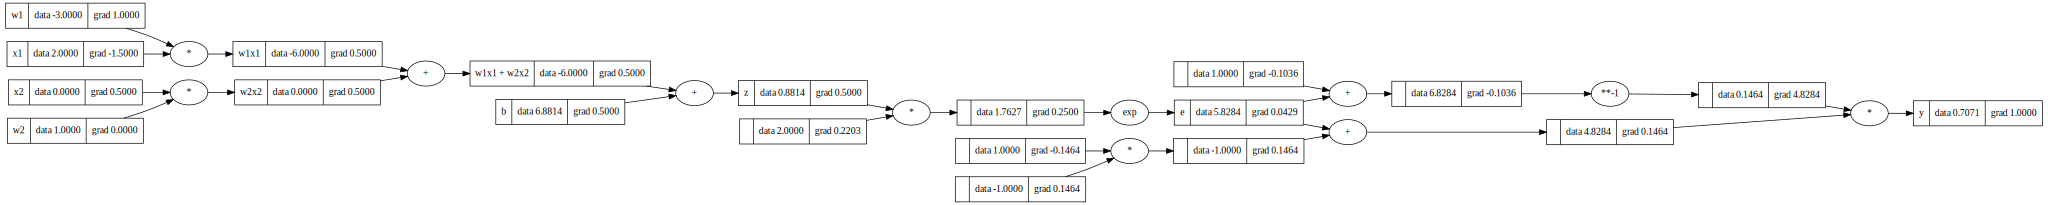

In [11]:
y.backward()
draw_dot(y)

In [12]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.88137]).double()
b.requires_grad = True

z = w1*x1 + w2*x2 + b
y = z.tanh()
print(f'Value of y.data after forward pass = {y.data}')

y.backward()
print(f'Value of x1.grad = {x1.grad.item()}')
print(f'Value of w1.grad = {w1.grad.item()}')
print(f'Value of x2.grad = {x2.grad.item()}')
print(f'Value of w2.grad = {w2.grad.item()}')

Value of y.data after forward pass = tensor([0.7071], dtype=torch.float64)
Value of x1.grad = -1.500007465833125
Value of w1.grad = 1.0000049772220834
Value of x2.grad = 0.5000024886110417
Value of w2.grad = 0.0


In [13]:
x = Value(2.0, label='x')
y = Value(3.0, label='y')

# Expression: z = ((x * y + 3)**2 - (y / (x + 1))) * ReLU(x - y) + tanh(x) * sigmoid(y) + exp(-x)
a = x * y
b = a + 3
c = b ** 2
d = y / (x + 1)
e = c - d
f = x - y
g = f.relu()
h = e * g
i = x.tanh()
j = y.sigmoid()
k = i * j
l = (-x).exp()
z = h + k + l

# Backward pass
z.backward()

# Pytorch implementation
x_torch = torch.tensor([2.0]).double()
x_torch.requires_grad=True
y_torch = torch.tensor([3.0]).double()
y_torch.requires_grad=True

# Expression: z = ((x * y + 3)**2 - (y / (x + 1))) * ReLU(x - y) + tanh(x) * sigmoid(y) + exp(-x)
a_torch = x_torch * y_torch
b_torch = a_torch + 3
c_torch = b_torch ** 2
d_torch = y_torch / (x_torch + 1)
e_torch = c_torch - d_torch
f_torch = x_torch - y_torch
g_torch = f_torch.relu()
h_torch = e_torch * g_torch
i_torch = x_torch.tanh()
j_torch = y_torch.sigmoid()
k_torch = i_torch * j_torch
l_torch = (-x_torch).exp()
z_torch = h_torch + k_torch + l_torch

# Backward pass
z_torch.backward()

# Computational graph
dot = draw_dot(z)
dot.render(filename='autograd_graph', format='png', cleanup=True)

'autograd_graph.png'

In [14]:
print(z.data)
print(z_torch.item())

1.0536430135600776
1.0536430135600776


In [15]:
print(x.grad, y.grad)
print(x_torch.grad.item(), y_torch.grad.item())

-0.06803513544282493 0.043551545956299696
-0.06803513544282493 0.0435515459562997


In [16]:
A = Value(random.uniform(-1, 1), label='A')
b = random.uniform(-1, 1)
print(b)
A*b

0.27001889310669336


Value(data=-0.09694501121351166, prev={Value(data=-0.3590304741202146, prev=set(), label=A), Value(data=0.27001889310669336, prev=set(), label=)}, label=)

In [17]:
# Configure logging

logging.basicConfig(level = logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class Config:
  """Config class for hyperparameters."""
  learning_rate : float = 0.001
  batch_size : int = 32
  epochs : int = 10
  hidden_sizes : List[int] = None
  activation : str = 'relu'
  optimizer : str = 'adam'
  weight_init : str = 'he'
  log_interval : int = 100

  def __post_init__(self):
    if self.hidden_sizes is None:
      self.hidden_sizes = [128, 64]

  @classmethod
  def from_json(cls, json_path : str) -> 'Config':
    """Load the configuration from JSON file."""
    with open(json_path, 'r') as f:
      config_dict = json.load(f)
    return cls(**config_dict)

# Utility functions
def one_hot(y : int, num_classes : int) -> List[Value]:
  """Create one-hot encoded vector."""
  return [Value(1.0) if i == y else Value(0.0) for i in range(num_classes)]

def clip_gradient(parameters : List[Value], max_norm : float = 1.0):
  """Clip gradients to prevent exploding gradients."""
  total_norm = math.sqrt(sum(p.grad**2 for p in parameters))
  if total_norm > max_norm:
    clip_coef = max_norm / (total_norm + 1e-6)
    for p in parameters:
      p.grad *= clip_coef

def predictions_from_outputs(outputs : List[List[Value]]) -> List[int]:
  """Convert the model outputs to predicted class indices."""
  predictions = []
  for output in outputs:
    pred_class = max(range(len(output)), key = lambda i : output[i].data) # returns the index i with the highest score
    predictions.append(pred_class)
  return predictions

# Weight Initialization
class WeightInitializer:

  @staticmethod
  def xavier_uniform(nin : int, nout : int) -> float:
    limit = math.sqrt(6.0 / (nin + nout))
    return random.uniform(-limit, limit)

  @staticmethod
  def he_uniform(nin : int) -> float:
    limit = math.sqrt(6.0 / nin)
    return random.uniform(-limit, limit)

  @staticmethod
  def he_normal(nin : int) -> float:
    std = math.sqrt(2.0 / nin)
    return random.gauss(0, std)

  @staticmethod
  def normal(mean : float = 0.0, std : float = 0.01) -> float:
    return random.gauss(mean, std)

# Neural Network Component
class Module(ABC):
  """Base class for all neural network modules."""

  @abstractmethod
  def __call__(self, x : List[Value]) -> Union[Value, List[Value]]:
    pass

  @abstractmethod
  def parameters(self) -> List[Value]:
    pass

  def zero_grad(self):
    """Zero out gradients of all parameters."""
    for p in self.parameters():
      p.grad = 0.0

class Neuron:
  def __init__(self, nin : int, activation : str = 'relu', init_method : str = 'he'):
    self.nin = nin
    self.activation = activation

    if init_method == 'he':
      self.w = [Value(WeightInitializer.he_uniform(nin)) for _ in range(nin)]
    elif init_method == 'xavier':
      self.w = [Value(WeightInitializer.xavier_uniform(nin)) for _ in range(nin)]
    elif init_method == 'he_normal':
      self.w = [Value(WeightInitializer.he_normal(nin)) for _ in range(nin)]
    else:
      self.w = [Value(WeightInitializer.normal()) for _ in range(nin)]

    self.b = Value(0.0)

  def __call__(self, x : List[Value]) -> Value:
    assert len(x) == self.nin, f"Expected {self.nin} inputs, got {len(x)}"

    # Linear transformation
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)

    # Apply activation
    if self.activation == 'relu':
      return act.relu()
    elif self.activation == 'tanh':
      return act.tanh()
    elif self.activation == 'sigmoid':
      return act.sigmoid()
    elif self.activation == 'linear':
      return act
    else:
      raise ValueError(f"Unknown activation: {self.activation}")

  def parameters(self) -> List[Value]:
    return self.w + [self.b]

class Layer(Module):
  def __init__(self, nin : int, nout : int, activation : str = 'relu', init_method : str = 'he'):
    self.nin = nin
    self.nout = nout
    self.neurons = [Neuron(nin, activation, init_method) for _ in range(nout)]

  def __call__(self, x : List[Value]) -> List[Value]:
    outputs = [neuron(x) for neuron in self.neurons]
    return outputs

  def parameters(self) -> List[Value]:
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP(Module):
  def __init__(self, nin : int, architecture : List[int], activations : Optional[List[str]] = None, init_method : str = 'he'):
    self.nin = nin
    self.architecture = architecture

    if activations is None:
      activations = ['relu'] * (len(architecture) - 1) + ['linear']
    self.activations = activations

    assert len(activations) == len(architecture), "Number of activations must match the number of layers"

    layer_sizes = [nin] + architecture
    self.layers = []

    for i in range(len(architecture)):
      layer = Layer(layer_sizes[i], layer_sizes[i+1], activations[i], init_method)
      self.layers.append(layer)

    logger.info(f"Created MLP with architecture: {nin} -> {' -> '.join(map(str, architecture))}")

  def __call__(self, x : List[Value]) -> List[Value]:
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self) -> List[Value]:
    return [p for layer in self.layers for p in layer.parameters()]

# Loss Functions
class Loss(ABC):
  """Base class for loss functions."""

  @abstractmethod
  def __call__(self, y_pred : List[Value], y_true : List[Value]) -> Value:
    pass

class MSELoss(Loss):
  """Mean Squared Error loss."""

  def __call__(self, y_pred : List[Value], y_true : List[Value]) -> Value:
    assert len(y_pred) == len(y_true), "Prediction and target size mismatch"

    return sum((yp - yt)**2 for yp, yt in zip(y_pred, y_true))/len(y_pred)

class CrossEntropyLoss(Loss):
  """Cross-entropy loss with numerical stability."""

  def __call__(self, y_pred : List[Value], y_true : List[Value]) -> Value:
    assert len(y_pred) == len(y_true), "Prediction and target size mismatch"

    # Using Log-softmax for numerical stability
    max_val = max(yp.data for yp in y_pred)
    shifted_logits = [yp - max_val for yp in y_pred]
    log_sum_exp = max_val + sum(shifted.exp() for shifted in shifted_logits).log()

    log_probs = [yp - log_sum_exp for yp in y_pred]

    # Cross-entropy loss
    loss = Value(0.0)
    for log_prob, target in zip(log_probs, y_true):
      loss = loss + (target * log_prob * -1)

    return loss

class BinaryCrossEntropyLoss(Loss):
  """Binary Cross-entropy loss with numerical stability."""

  def __call__(self, y_pred : List[Value], y_true : List[Value]) -> Value:
    assert len(y_pred) == len(y_true), "Prediction and target size mismatch"

    loss = Value(0.0)
    for yp, yt in zip(y_pred, y_true):
      sig = yp.sigmoid()
      log_sig = yp - (Value(1.0) + yp.exp()).log()
      log_one_minus_sig = (-yp) - (Value(1.0) + (-yp).exp()).log()

      loss = loss + (yt * log_sig * -1) + ((Value(1.0) - yt) * log_one_minus_sig * -1)

    return loss / len(y_pred)

class Optimizer(ABC):
  """Base class for optimizers."""

  def __init__(self, parameters : List[Value]):
    self.parameters = parameters

  def zero_grad(self):
    for p in self.parameters:
      p.grad = 0.0

  @abstractmethod
  def step(self):
    pass

class SGD(Optimizer):
  """Stochastic Gradient Descent with momentum."""

  def __init__(self, parameters : List[Value], lr : float = 0.01, momentum : float = 0.0, weight_decay : float = 0.0):
    super().__init__(parameters)
    self.lr = lr
    self.momentum = momentum
    self.weight_decay = weight_decay
    self.velocity = [0.0] * len(parameters)

  def step(self):
    for i, p in enumerate(self.parameters):
      if self.weight_decay > 0: # Weight decay (L2 regularization)
        p.grad += self.weight_decay * p.data

      # Momentum
      self.velocity[i] = self.momentum * self.velocity[i] + p.grad
      p.data -= self.lr * self.velocity[i]

class Adam(Optimizer):
  """Adam optimizer with bias correction."""

  def __init__(self, parameters : List[Value], lr : float = 0.001, beta1 : float = 0.9, beta2 : float = 0.999, eps : float = 1e-8, weight_decay : float = 0.0):
    super().__init__(parameters)
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.eps = eps
    self.weight_decay = weight_decay
    self.t = 0
    self.m = [0.0] * len(parameters) # exponentially weighted average of gradients (momentum)
    self.v = [0.0] * len(parameters) # exponentially weighted average of squared gradients (RMS)

  def step(self):
    self.t += 1

    for i, p in enumerate(self.parameters):
      if self.weight_decay > 0: # Weight decay (L2 regularization)
        p.grad += self.weight_decay * p.data

      # Update biased first moment estimate
      self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad

      # Update biased second raw moment estimate
      self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad ** 2)

      # Compute bias-corrected first moment estimate
      m_hat = self.m[i] / (1 - self.beta1 ** self.t)

      # Compute bias-corrected second raw moment estimate
      v_hat = self.v[i] / (1 - self.beta2 ** self.t)

      # Update parameters
      p.data -= self.lr * m_hat / (math.sqrt(v_hat) + self.eps)

# Learning rate schedulers
class LRScheduler(ABC):
  """Base class for learning rate scheduler."""

  def __init__(self, optimizer : Optimizer):
    self.optimizer = optimizer
    self.base_lr = optimizer.lr

  @abstractmethod
  def step(self, epoch : int):
    pass

class StepLR(LRScheduler):
  """Step learning rate scheduler."""

  def __init__(self, optimizer : Optimizer, step_size : int, gamma : float = 0.1):
    super().__init__(optimizer)
    self.step_size = step_size
    self.gamma = gamma

  def step(self, epoch : int):
    if epoch > 0 and epoch % self.step_size == 0:
      self.optimizer.lr *= self.gamma
      logger.info(f"Learning rate reduced to {self.optimizer.lr}")

# Metrics
class Metrics:
  """Collection of evaluation metrics."""

  @staticmethod
  def accuracy(y_pred : List[int], y_true : List[int]) -> float:
    assert len(y_pred) == len(y_true), "Prediction and target size mismatch"

    correct = sum(1 for pred, true in zip(y_pred, y_true) if pred == true)
    return correct / len(y_pred)

  @staticmethod
  def precision_recall_f1(y_pred : List[int], y_true : List[int], num_classes : int) -> Dict[str, float]:
    assert len(y_pred) == len(y_true), "Prediction and target size mismatch"

    confusion = [[0 for _ in range(num_classes)] for _ in range(num_classes)]

    for pred, true in zip(y_pred, y_true):
      if 0 <= pred < num_classes and 0 <= true < num_classes:
        confusion[true][pred] += 1

    precision = []
    recall = []

    for i in range(num_classes):
      tp = confusion[i][i]
      fp = sum(confusion[j][i] for j in range(num_classes)) - tp
      fn = sum(confusion[i][j] for j in range(num_classes)) - tp

      prec = tp / (tp + fp) if (tp + fp) > 0 else 0
      rec = tp / (tp + fn) if (tp + fn) > 0 else 0

      precision.append(prec)
      recall.append(rec)

    average_precision = sum(precision) / len(precision)
    average_recall = sum(recall) / len(recall)

    average_f1 = (2 * average_precision * average_recall) / (average_precision + average_recall) if (average_precision + average_recall) > 0 else 0

    return {'precision' : average_precision, 'recall' : average_recall, 'f1' : average_f1}

# Training utilities
class Trainer:
  """Memory-efficient training class."""

  def __init__(self, model : MLP, optimizer : Optimizer, loss_fn : Loss, config : Config, scheduler : Optional[LRScheduler] = None):
    self.model = model
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.config = config
    self.scheduler = scheduler
    self.history = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : []}

  def train_epoch(self, X_train : List[List[float]], y_train : List[int]) -> Tuple[float, float]:
    """Train for one epoch with memory-efficient processing."""
    total_loss = 0.0
    all_predictions = []
    n_samples = len(X_train)

    # Process samples individually to avoid huge computational graphs
    for i in range(0, n_samples, self.config.batch_size):
      batch_end = min(i + self.config.batch_size, n_samples)
      batch_size = batch_end - i

      # Zero gradients for this batch
      self.optimizer.zero_grad()

      batch_loss = 0.0
      batch_predictions = []

      # Process each sample in the batch
      for j in range(i, batch_end):
        x, y = X_train[j], y_train[j]

        # Forward pass
        x_val = [Value(xi) for xi in x]
        y_pred = self.model(x_val)

        # Get prediction for accuracy calculation
        pred_class = max(range(len(y_pred)), key=lambda k: y_pred[k].data)
        batch_predictions.append(pred_class)

        # Calculate loss
        y_true = one_hot(y, len(y_pred))
        loss = self.loss_fn(y_pred, y_true)

        batch_loss += loss.data

        # Backward pass for this sample
        loss.backward()

      # Now scaling the gradients by batch size (averaging them)
      for param in self.model.parameters():
        param.grad /= batch_size

      # Clip gradients
      clip_gradient(self.model.parameters(), max_norm=1.0)

      # Update parameters
      self.optimizer.step()

      # For logging, using average loss
      avg_batch_loss = batch_loss / batch_size
      total_loss += avg_batch_loss
      all_predictions.extend(batch_predictions)

      # Logging
      if (i // self.config.batch_size) % self.config.log_interval == 0:
        logger.info(f"Batch {i//self.config.batch_size + 1}/{(n_samples-1)//self.config.batch_size + 1}, Loss: {avg_batch_loss:.4f}")

    avg_loss = total_loss / ((n_samples - 1) // self.config.batch_size + 1)

    # Calculate accuracy
    actual_labels = y_train[:len(all_predictions)]
    accuracy = Metrics.accuracy(all_predictions, actual_labels)

    return avg_loss, accuracy

  def evaluate(self, X_test : List[List[float]], y_test : List[int]) -> Dict[str, float]:
    """Evaluate the model on test set."""
    predictions = []
    total_loss = 0.0

    for x, y in zip(X_test, y_test):
      # Forward pass
      x_val = [Value(xi) for xi in x]
      y_pred = self.model(x_val)

      # Get prediction
      pred_class = max(range(len(y_pred)), key=lambda k: y_pred[k].data)
      predictions.append(pred_class)

      # Calculate loss
      y_true = one_hot(y, len(y_pred))
      loss = self.loss_fn(y_pred, y_true)
      total_loss += loss.data

    avg_loss = total_loss / len(X_test)

    # Calculate metrics
    accuracy = Metrics.accuracy(predictions, y_test)
    num_classes = len(set(y_test))
    detailed_metrics = Metrics.precision_recall_f1(predictions, y_test, num_classes)

    return {
      'loss': avg_loss,
      'accuracy': accuracy,
      'precision': detailed_metrics['precision'],
      'recall': detailed_metrics['recall'],
      'f1': detailed_metrics['f1']
    }

  def train(self, X_train : List[List[float]], y_train : List[int], X_val : Optional[List[List[float]]] = None, y_val : Optional[List[int]] = None) -> Dict[str, List[float]]:
    """Memory-efficient training loop."""

    logger.info("Starting training.")
    logger.info(f"Config: {self.config}")

    best_val_acc = 0.0

    for epoch in range(self.config.epochs):
      logger.info(f"\nEpoch {epoch + 1}/{self.config.epochs}")

      # Training
      train_loss, train_acc = self.train_epoch(X_train, y_train)
      self.history['train_loss'].append(train_loss)
      self.history['train_acc'].append(train_acc)

      # Validation
      if X_val is not None and y_val is not None:
        val_metrics = self.evaluate(X_val, y_val)
        self.history['val_loss'].append(val_metrics['loss'])
        self.history['val_acc'].append(val_metrics['accuracy'])

        logger.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        logger.info(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
        logger.info(f"Val Precision: {val_metrics['precision']:.4f}, Val Recall: {val_metrics['recall']:.4f}, Val F1: {val_metrics['f1']:.4f}")

        if val_metrics['accuracy'] > best_val_acc:
          best_val_acc = val_metrics['accuracy']
          logger.info(f"New best validation accuracy: {best_val_acc:.4f}")
      else:
        logger.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

      # Learning rate scheduling
      if self.scheduler:
        self.scheduler.step(epoch)

    logger.info("Training completed!")
    return self.history

Creating blobs dataset.
Dataset created:
  Training samples: 800
  Test samples: 200
  Features: 2
  Classes: 3


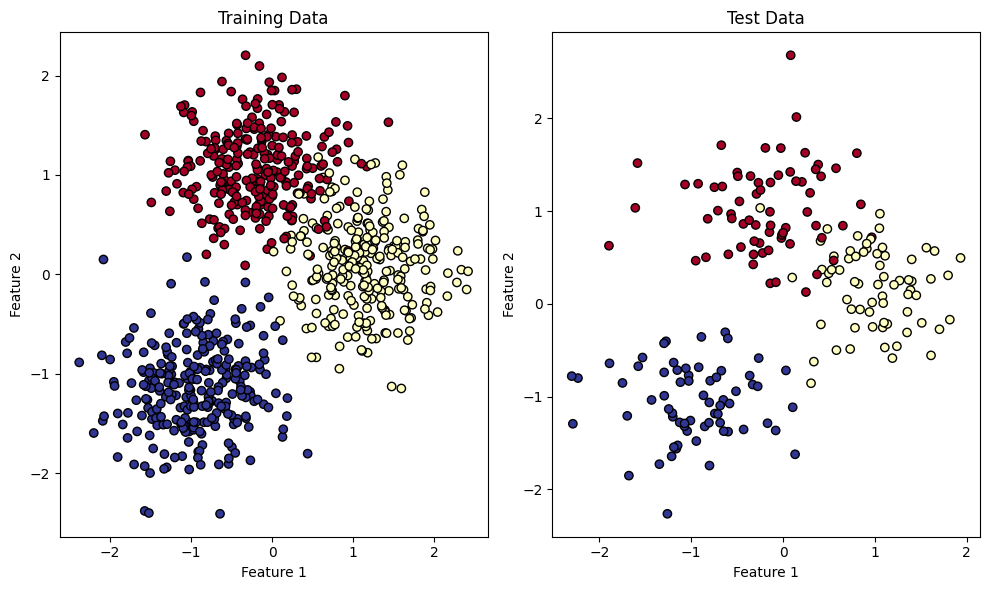


Building model.

Starting training.

Final evaluation.

Final Test Metrics:
  loss: 0.1122
  accuracy: 0.9600
  precision: 0.9602
  recall: 0.9602
  f1: 0.9602


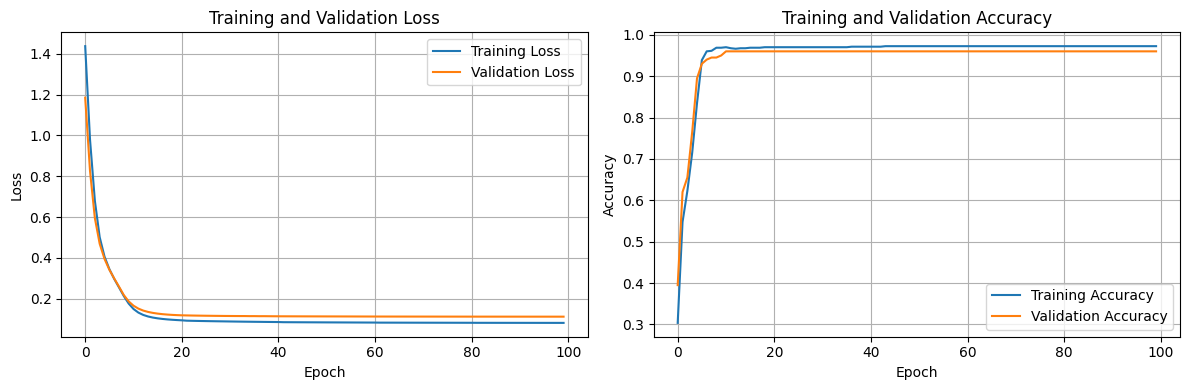


Generating decision boundary plot.


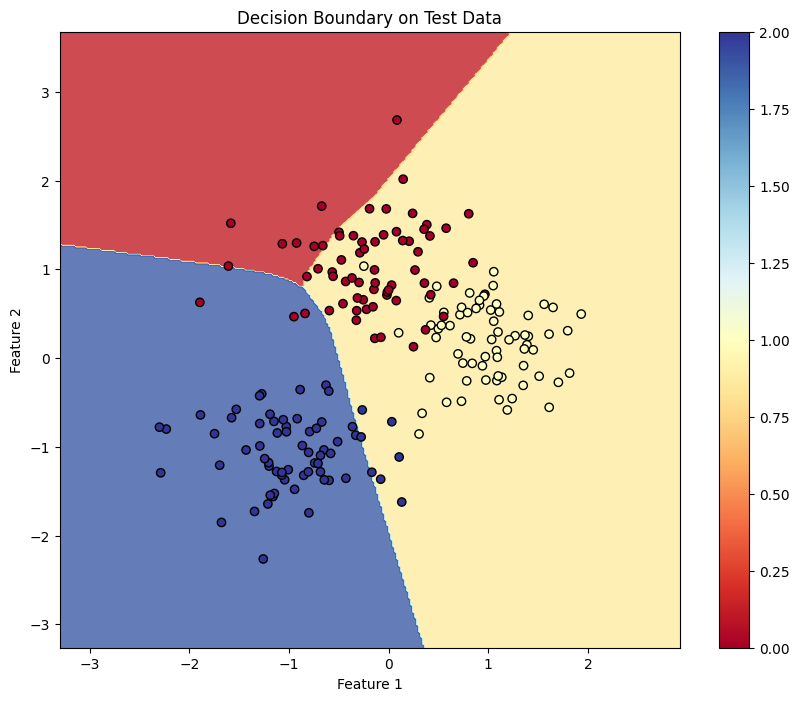

In [18]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def create_blobs_dataset(n_samples=1000, n_features=2, n_classes=3, random_state=42):
    """Create a blob dataset perfect for testing neural networks."""

    # Generate the data
    X, y = make_blobs(
        n_samples=n_samples,
        centers=n_classes,
        n_features=n_features,
        random_state=random_state,
        cluster_std=1.5,
        center_box=(-5, 5)
    )

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )

    # Normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, scaler

def plot_decision_boundary(model, X, y, scaler, title="Decision Boundary"):
    """Plot the decision boundary of the trained model."""

    # Create a mesh to plot the decision boundary
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    # Get predictions for the mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_scaled = scaler.transform(mesh_points)

    # Predict on mesh points
    predictions = []
    for point in mesh_scaled:
        x_val = [Value(xi) for xi in point]
        y_pred = model(x_val)
        pred_class = max(range(len(y_pred)), key=lambda i: y_pred[i].data)
        predictions.append(pred_class)

    predictions = np.array(predictions).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, predictions, alpha=0.8, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

def main():
    """Main training loop for make_blobs dataset."""

    # Create dataset
    print("Creating blobs dataset.")
    X_train, X_test, y_train, y_test, scaler = create_blobs_dataset(
        n_samples=1000,
        n_features=2,
        n_classes=3,
        random_state=42
    )

    print(f"Dataset created:")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Test samples: {len(X_test)}")
    print(f"  Features: {X_train.shape[1]}")
    print(f"  Classes: {len(np.unique(y_train))}")

    # Plot original data
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.title('Training Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.subplot(1, 2, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.title('Test Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.tight_layout()
    plt.show()

    # Create configuration
    config = Config(
        learning_rate=0.001,
        batch_size=16,
        epochs=100,
        hidden_sizes=[8, 6],  # Small network: 2 → 8 → 6 → 3
        activation='relu',
        optimizer='adam',
        weight_init='he',
        log_interval=10
    )

    # Build model
    print("\nBuilding model.")
    model = MLP(
        nin=2,  # 2 input features
        architecture=config.hidden_sizes + [3],  # 3 output classes
        activations=['relu', 'relu', 'linear'],
        init_method=config.weight_init
    )

    # Loss and optimizer
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=config.learning_rate)

    scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

    # Create trainer
    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        config=config,
        scheduler=scheduler
    )

    # Train the model
    print("\nStarting training.")
    history = trainer.train(
        X_train.tolist(),
        y_train.tolist(),
        X_test.tolist(),
        y_test.tolist()
    )

    # Final evaluation
    print("\nFinal evaluation.")
    final_metrics = trainer.evaluate(X_test.tolist(), y_test.tolist())

    print("\nFinal Test Metrics:")
    for metric, value in final_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot decision boundary
    print("\nGenerating decision boundary plot.")
    plot_decision_boundary(model, X_test, y_test, scaler, "Decision Boundary on Test Data")

    return model, history, final_metrics

if __name__ == "__main__":
    model, history, metrics = main()